# 1. Loading Libraries and Data
## 1.1. Loading packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime,date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
import pickle as pkl
from pylab import rcParams
import statsmodels.api as sm


In [2]:
os.getcwd()

'C:\\Users\\mikul\\Documents\\algorithms'

# 1.2. Loading Data

In [3]:
gen = pd.read_csv('./entsoe_api/data/raw/A75_A16_10YPL-AREA-----S_201901012300_201912312300.csv')


In [4]:
gen = gen.rename(columns = {
    'Unnamed: 0': 'Time',
    '0': 'Value'
})

In [5]:
# Merging the data together to one dataframe
no_gens = 10

for i in range(no_gens):
    new_data = gen.iloc[i*int(gen.shape[0] / no_gens):(i+1)*int(gen.shape[0] / no_gens)].Value.rename(i).reset_index()[i]
    if i == 0:
        final_gen = pd.DataFrame(new_data)
    else:
        final_gen = pd.concat([final_gen, new_data], axis = 1)
        
final_gen

,0,1,2,3,4,5,6,7,8,9
0,215,1906,57,871,6286,204,0,174,0,4394
1,217,1809,56,850,6249,206,0,172,0,4405
2,217,1798,52,847,6178,205,0,172,0,4303
3,217,1943,50,869,6382,204,0,172,0,4280
4,217,2219,51,874,6535,203,0,172,0,4375
...,...,...,...,...,...,...,...,...,...,...
8731,304,3092,53,1326,7449,218,181,233,58,3951
8732,304,2939,53,1395,7503,218,167,228,7,3744
8733,258,2734,53,1432,7453,218,107,194,0,3657
8734,229,2719,52,1438,7372,218,0,174,0,3336


In [6]:
final_gen.divide(final_gen.max(axis = 0)).describe().round(2)

,0,1,2,3,4,5,6,7,8,9
count,8736.00,8736.00,8736.00,8736.00,8736.00,8736.00,8736.00,8736.00,8736.00,8736.00
mean,0.76,0.64,0.73,0.70,0.63,0.68,0.08,0.47,0.25,0.32
std,0.24,0.14,0.14,0.13,0.12,0.10,0.13,0.19,0.36,0.23
min,0.06,0.25,0.00,0.22,0.36,0.43,0.00,0.19,0.00,0.00
25%,0.76,0.52,0.63,0.62,0.53,0.60,0.00,0.30,0.00,0.13
50%,0.83,0.63,0.77,0.70,0.62,0.67,0.01,0.41,0.00,0.26
75%,0.92,0.76,0.83,0.80,0.72,0.73,0.11,0.62,0.62,0.46
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [7]:
final_gen.describe().round()

,0,1,2,3,4,5,6,7,8,9
count,8736.0,8736.0,8736.0,8736.0,8736.0,8736.0,8736.0,8736.0,8736.0,8736.0
mean,236.0,4318.0,63.0,1209.0,8708.0,185.0,104.0,160.0,14.0,1655.0
std,74.0,970.0,12.0,220.0,1700.0,28.0,173.0,66.0,21.0,1220.0
min,18.0,1689.0,0.0,381.0,4951.0,117.0,0.0,67.0,0.0,8.0
25%,236.0,3509.0,54.0,1070.0,7392.0,163.0,0.0,102.0,0.0,680.0
50%,257.0,4286.0,66.0,1200.0,8632.0,181.0,7.0,141.0,0.0,1336.0
75%,285.0,5128.0,71.0,1382.0,10005.0,199.0,143.0,215.0,36.0,2397.0
max,310.0,6773.0,86.0,1718.0,13912.0,272.0,1332.0,344.0,58.0,5222.0


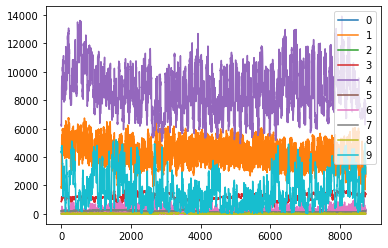

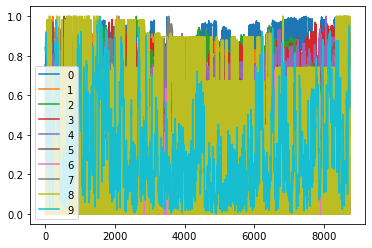

In [8]:
final_gen.plot();
final_gen.divide(final_gen.max(axis = 0)).plot();

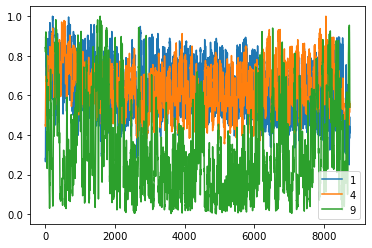

In [9]:
final_gen.divide(final_gen.max(axis = 0))[[1, 4, 9]].plot();

In [10]:
series = final_gen.loc[:,4]

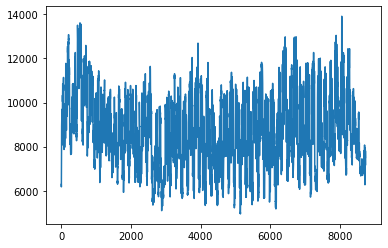

In [11]:
series.plot()

# Prepare the datasets
- normalize the data (check if installed capacity increased or if some capacity were under maintenance),
- add more datapoints (not just single one, make a table),
- batch them, seq2seq
- 

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds 

In [13]:
def window_dataset(series, window_size = 14, seq2seq = True, batch_size = 32, shuffle_buffer = 1000):
    # Expand dimensions to 2 dims, otherwise ?
    dataset = tf.expand_dims(series, axis = -1)
    # turn to tensor_slices
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    # 
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle the dataset, so that it's not biased
    dataset = dataset.shuffle(shuffle_buffer)
    
    # seq2seq (sequence-to-seqence) is using sequences of data (e.g. X=14 lags) to forecast sequence of data (also X lags).
    # That forecasted sequence will have most of the data of the used sequence - it will lack first datapoint and have the last datapoint of the window 
    # (single point that needs to be forecasted).
    if seq2seq:
        dataset = dataset.map(lambda window: (window[:-1], window[1:]))
        
    # Otherwise, you just use a sequence to forecast a single point (next datapoint)
    else:
        dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [14]:
def split_tf(dataset, split_time = 0.75):
    """
    """
    if split_time > 1:
        x_train = dataset[:split_time]
        x_valid = dataset[split_time:]
    
    else:
        x_train = dataset[:int(split_time*dataset.shape[0])]
        x_valid = dataset[int(split_time*dataset.shape[0]):]
    
    return x_train, x_valid

In [15]:
x_nontest, x_test = split_tf(series)
x_train, x_valid = split_tf(x_nontest)

x_train_norm = x_train.divide(x_train.max() * 1.5)
x_valid_norm = x_valid.divide(x_train.max() * 1.5)
x_test_norm = x_test.divide(x_nontest.max() * 1.5)

x_train_norm

0       0.307888
1       0.306076
2       0.302598
3       0.312590
4       0.320084
          ...   
4909    0.519139
4910    0.520216
4911    0.509000
4912    0.506306
4913    0.496853
Name: 4, Length: 4914, dtype: float64

# Do the easy modelling 
- easy benchmark such as last value or prophet (or both)
- RNN and CNN, dropout.

### Benchmarks

In [16]:
from fbprophet import Prophet
from sklearn.linear_model import Lasso


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [17]:
series

0       6286
1       6249
2       6178
3       6382
4       6535
        ... 
8731    7449
8732    7503
8733    7453
8734    7372
8735    7189
Name: 4, Length: 8736, dtype: int64

### Prophet

In [18]:
forecasting_since = pd.to_datetime('2019-01-02 00:00')
forecasting_till = pd.to_datetime('2019-12-31 23:00')

In [19]:
prophet_series = series
prophet_series.index = pd.date_range(start=forecasting_since, end=forecasting_till, freq = 'H')
prophet_series = prophet_series.rename('Data').rename_axis('Time')
prophet_series

Time
2019-01-02 00:00:00    6286
2019-01-02 01:00:00    6249
2019-01-02 02:00:00    6178
2019-01-02 03:00:00    6382
2019-01-02 04:00:00    6535
                       ... 
2019-12-31 19:00:00    7449
2019-12-31 20:00:00    7503
2019-12-31 21:00:00    7453
2019-12-31 22:00:00    7372
2019-12-31 23:00:00    7189
Freq: H, Name: Data, Length: 8736, dtype: int64

In [20]:
def dataset_prophet(series):
    """
    Prophet needs preprocessing - there have to be 2 columns, 'ds' and 'y' 

    This goes with assumption that 'series' is pd.Series,
    has index as pd.datetime(),
    and series itself is called 'Data'.
    """
    prophet_series = pd.DataFrame(series)
    # prophet_series['Time'] = prophet_series.index
    prophet_series = prophet_series.reset_index()
    prophet_series = prophet_series.loc[:,['Data','Time']]
    prophet_series.columns = ['y', 'ds']
    
    return prophet_series

In [21]:
def plot_prophet_prediction(m, test_y, y_true, forecasting_since, forecasting_till):

    m.plot(test_y)
    plt.plot(y_true.ds, y_true.y, color = 'red')
    plt.ylabel('Average daily demand [MWh]')
    plt.xlabel('Time')
    plt.xlim((pd.to_datetime(forecasting_since), pd.to_datetime(forecasting_till)))
    plt.legend(['Train data observations', 'Trend - Model', 'Test data observations', 'Confidence Interval'])

In [22]:
prophet_series = dataset_prophet(prophet_series)

In [23]:
prophet_nontest, prophet_test = split_tf(prophet_series)
prophet_train, prophet_valid = split_tf(prophet_nontest)

In [24]:
def predict_prophet(train_df, forecasting_since, forecasting_till):
    # Define a model and its coefficients
    m = Prophet(changepoint_prior_scale=0.01, yearly_seasonality=False, weekly_seasonality=True, growth='linear')
    # Fit the model with training data
    m.fit(train_df)
    # Define a future dataframe for forecasting purposes
    a = (pd.to_datetime(forecasting_till) - pd.to_datetime(forecasting_since))
    model_fit = m.make_future_dataframe(periods = int(a.days * 24 + a.seconds / 3600 + 1), freq='H', include_history = True)
    
    # Prediction
    test_y = m.predict(model_fit)
    return test_y, m, model_fit

In [25]:
test_y, m, model_fit = predict_prophet(prophet_train, prophet_train.ds.iloc[0], prophet_valid.ds.iloc[-1])

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


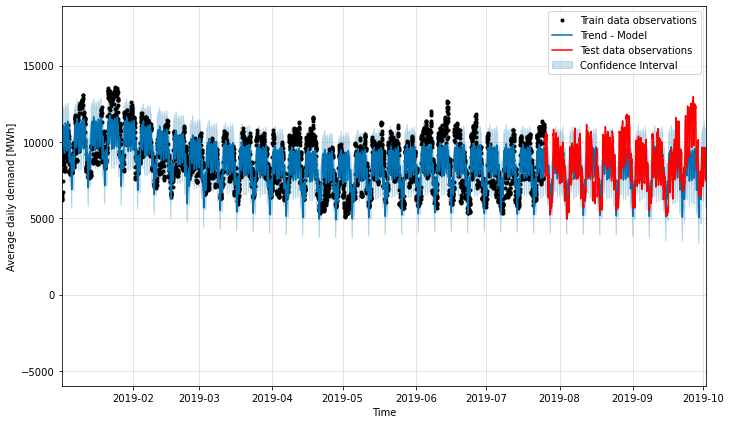

In [26]:
plot_prophet_prediction(m, test_y, prophet_valid, prophet_train.ds.iloc[0], prophet_valid.ds.iloc[-1])

### Creating model

In [27]:
MY_SEED = 123

tf.keras.backend.clear_session()
tf.random.set_seed(MY_SEED)
np.random.seed(MY_SEED)


In [28]:
window_size = 15
train_set = window_dataset(x_train_norm, window_size, seq2seq = False, batch_size = 32)
valid_set = window_dataset(x_valid_norm, window_size, seq2seq = False, batch_size = 32)
test_set = window_dataset(x_test_norm, window_size, seq2seq = False, batch_size = 32)


In [109]:
def tsa_model(rnn_units = 100, dropouting = 0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, dilation_rate = 4,
                               padding = 'causal', activation = 'relu', input_shape = [None, 1]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences = True),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences = True),
        tf.keras.layers.Dropout(rate = dropouting, seed = MY_SEED),
        tf.keras.layers.SimpleRNN(rnn_units),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
    ])
    
    model.compile(loss = tf.keras.losses.Huber(), 
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['mape'])
    
    return model


In [104]:
model = tsa_model()

In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint', save_best_only=True)

model.fit(train_set,
          epochs = 250,
          validation_data=valid_set,
          verbose = 1,
          callbacks = [early_stopping, model_checkpoint])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1/250
    154/Unknown - 17s 113ms/step - loss: 0.0039 - mape: 15.9806WARNING:tensorflow:Layer conv1d_23 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


154/154 [==============================] - 36s 232ms/step - loss: 0.0039 - mape: 15.9806 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/250
49/51 [===========================>..] - ETA: 0s - loss: 0.0015 - mape: 9.3076INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


154/154 [==============================] - 23s 149ms/step - loss: 0.0012 - mape: 8.3519 - val_loss: 0.0010 - val_mape: 8.4884
Epoch 3/250
154/154 [==============================] - 5s 31ms/step - loss: 6.0941e-04 - mape: 6.3134 - val_loss: 0.0018 - val_mape: 14.0350
Epoch 4/250
49/51 [===========================>..] - ETA: 0s - loss: 5.5432e-04 - mape: 5.8233 EINFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


154/154 [==============================] - 23s 151ms/step - loss: 5.3006e-04 - mape: 6.0745 - val_loss: 3.7700e-04 - val_mape: 5.2223
Epoch 5/250
49/51 [===========================>..] - ETA: 0s - loss: 4.0595e-04 - mape: 4.9145 ETA: 0s - loss: 4.0531e-04 - mape: 4.91INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


154/154 [==============================] - 23s 152ms/step - loss: 3.7093e-04 - mape: 4.9215 - val_loss: 2.5321e-04 - val_mape: 4.1260
Epoch 6/250
154/154 [==============================] - 5s 32ms/step - loss: 2.9056e-04 - mape: 4.5057 - val_loss: 4.8078e-04 - val_mape: 6.2310
Epoch 7/250
49/51 [===========================>..] - ETA: 0s - loss: 3.2701e-04 - mape: 4.5103INFO:tensorflow:Assets written to: model_checkpoint\assets


INFO:tensorflow:Assets written to: model_checkpoint\assets


KeyboardInterrupt: 

In [34]:
def model_forecast(model, series, window_size, batch_size = 32):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [35]:
test_pred = model_forecast(model, x_test_norm, window_size)[:, 0]
test_pred

array([0.5002262 , 0.48909786, 0.48320016, ..., 0.34897417, 0.34472734,
       0.3316164 ], dtype=float32)

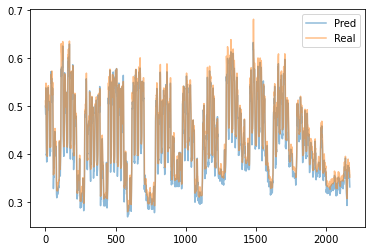

In [44]:
plt.plot(test_pred, alpha = 0.5);
plt.plot(np.array(x_test_norm[window_size-1:]), alpha = 0.5);
plt.legend(['Pred', 'Real']);

### Evaluation

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [107]:
# DL model
mean_absolute_percentage_error(test_pred, np.array(x_test_norm[window_size-1:]))

0.03564697994785758

In [106]:
# Prophet model
mean_absolute_percentage_error(prophet_valid.y,
                               test_y[(test_y.ds >= prophet_valid.ds.iloc[0]) & 
                                      (test_y.ds <= prophet_valid.ds.iloc[-1])].yhat)

0.0990137303542116

# Make a grid-search and cross-validation
- RNN and CNN,
- feature selection (dropout),
- different activation functions,

In [45]:
from sklearn.model_selection import KFold, RandomizedSearchCV


In [71]:
# include division to train, valid and test datasets

def sklearn_datasets(series, window_size):
    xy = pd.DataFrame()
    
    # Get samples of window_size length from series
    # get them without replacement
    for i in range(window_size+1):
        xy = xy.append(x_train_norm.shift(i))

    # shuffle 
        xy = xy.T.dropna(how='any').sample(frac=1)

    # divide into X and Y, where X is train data and Y is target
    X = xy.iloc[:,1:]
    Y = xy.iloc[:,0]
    
    return X,Y

In [62]:
nn_grid_params = {
    #'dropouting': [0.4, 0.5, 0.6, 0.7],
    #'rnn_units': [32, 64, 128, 256],
    'epochs': [50, 75, 100, 125]
}

In [110]:
model_ = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = tsa_model, epochs = 100)

In [111]:
bst_ = RandomizedSearchCV(estimator = model_, 
                          param_distributions = nn_grid_params, 
                          n_jobs= 1, 
                          n_iter = 2, 
                          cv = KFold(3),
                          verbose = 1, 
                          random_state = MY_SEED,
#                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)

In [112]:
xy = pd.DataFrame()

for i in range(window_size+1):
    xy = xy.append(x_train_norm.shift(i))

xy = xy.T.dropna(how='any').sample(frac=1)
X = xy.iloc[:,1:]
Y = xy.iloc[:,0]

In [130]:
X.columns = list(range(X.shape[1])) 
Y = Y.rename('target')

In [142]:
grid_result = bst_.fit(np.array(train_set))

TypeError: Singleton array array(<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>,
      dtype=object) cannot be considered a valid collection.

# Make a quantile regression, predictive interval, scenarios based on clustering

In [143]:
import tensorflow.keras.backend as K

def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
qs = [0.85, 0.9, 0.95]

for q in qs:
    model = tsa_model()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adam')
    
    model.fit(train_set,
              epochs = 70,
              validation_data=valid_set,
              verbose = 0)
        
    # Predict the quantile
    y_test = model_forecast(model,
                            series[split_time - window_size:-1],
                            window_size)[:, 0]
    plt.plot(y_test, label=q) # plot out this quantile

plt.plot(x_valid, label = 'real')
plt.legend()    
plt.show()
